In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../..'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../..'))
from openparticle import ParticleOperator, BosonOperator, FermionOperator, NumberOperator
import numpy as np
import cirq
from src.lobe.system import System
from cirq.contrib.svg import SVGCircuit
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.fermionic import fermionic_plus_hc_block_encoding, fermionic_product_block_encoding
from src.lobe.rescale import rescale_coefficients, get_numbers_of_bosonic_operators_in_terms
from src.lobe._utils import get_basis_of_full_system
from openparticle import generate_matrix
from functools import partial
from src.lobe.lcu import LCU
from openfermion import fermi_hubbard
from src.lobe.index import index_over_terms
from src.lobe.metrics import CircuitMetrics
from tests._utils import _validate_block_encoding

/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-05 13:19:33,486	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
def get_fermi_hubbard_hamiltonian(x_dim, y_dim, phs=False):
    fermi_hubbard_hamiltonian = ParticleOperator()
    for i, term in enumerate(fermi_hubbard(x_dim, y_dim, 1, 4, particle_hole_symmetry=phs)):
        po_term = None
        ops = str(term).split("[")[1][:-1].split(" ")
        if ops == [""]:
            continue
        
        for op_string in ops:
            if po_term is None:
                po_term = FermionOperator(op_string)
            else:
                po_term = po_term * FermionOperator(str(op_string))
        po_term = float(str(term).split("[")[0]) * po_term

        fermi_hubbard_hamiltonian += po_term
    return fermi_hubbard_hamiltonian

In [5]:
print(
    get_fermi_hubbard_hamiltonian(8, 8, phs=False).to_paulis(1 + (2*8**2)).n_terms,
    get_fermi_hubbard_hamiltonian(8, 8, phs=True).to_paulis(1 + (2*8**2)).n_terms
)

705 577


In [6]:
def get_active_fermionic_modes(operator):
    active_modes = []
    for term in operator.to_list():
        for op in term.split():
            index = str(op)[str(op).index("b")+1:]
            if "^" in index:
                index = index[:-2]
            index = int(index)
            if index not in active_modes:
                active_modes.append(index)
                
    return active_modes[::-1]

In [7]:
def lcu_ify(x_dim, y_dim, phs=True):
    operator = get_fermi_hubbard_hamiltonian(x_dim, y_dim, phs=phs)
    operator.remove_identity()
    
    max_bosonic_occupancy = 1
    lcu = LCU(operator, max_bosonic_occupancy=max_bosonic_occupancy, zero_threshold=1e-6)
    ctrls = ([cirq.LineQubit(-1000000)], [1])
    circuit = cirq.Circuit()
    circuit += cirq.X.on(ctrls[0][0])
    circuit += lcu.get_circuit(ctrls=ctrls)
    circuit += cirq.X.on(ctrls[0][0])
    fake_sys = System(1, max_bosonic_occupancy, 1000 + lcu.number_of_index_qubits, operator.has_fermions, operator.has_antifermions, operator.has_bosons)
    _validate_block_encoding(circuit, fake_sys, lcu.one_norm, operator, len(lcu.index_register), max_bosonic_occupancy, max_qubits=16, using_pytest=False)

    return lcu.circuit_metrics, lcu.one_norm, len(lcu.index_register)

In [8]:
def lobotomize(x_dim, y_dim):
    operator = get_fermi_hubbard_hamiltonian(x_dim, y_dim)
    operator.remove_identity()
    terms = operator.group()

    
    number_of_block_encoding_ancillae = 1
    index_register = [cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(terms)))))]
    block_encoding_ancillae = [cirq.LineQubit(-100 - i - len(index_register)) for i in range(number_of_block_encoding_ancillae)]
    ctrls = ([cirq.LineQubit(0)], [1])
    clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
    system = System(operator.max_mode + 1, 1, 1000, operator.has_fermions, operator.has_antifermions, operator.has_bosons)

    block_encoding_functions = []
    rescaling_factors = []
    for term in terms:
        if len(term.to_list()[0].split()) == 4:
            block_encoding_functions.append(
                partial(
                fermionic_product_block_encoding,
                    system=system,
                    block_encoding_ancilla=block_encoding_ancillae[0],
                    active_indices=get_active_fermionic_modes(term),
                    operator_types=[2, 2],
                    clean_ancillae=clean_ancillae[::-1],
            ))
            rescaling_factors.append(1)
        elif len(term.to_list()[0].split()) == 2:
            block_encoding_functions.append(
                partial(
                fermionic_plus_hc_block_encoding,
                    system=system,
                    block_encoding_ancilla=block_encoding_ancillae[0],
                    active_indices=get_active_fermionic_modes(term),
                    operator_types=[0, 1],
                    sign=-1,
                    clean_ancillae=clean_ancillae[::-1],
            ))
            rescaling_factors.append(1)
        else:
            raise RuntimeError("Term not expected: ", term)


    rescaled_coefficients, overall_rescaling_factor = rescale_coefficients(
        [term.coeffs[0] for term in terms],
        rescaling_factors
    )
    target_state = get_target_state(rescaled_coefficients)
    
    gates = []
    metrics = CircuitMetrics()

    gates.append(cirq.X.on(ctrls[0][0]))

    _gates, _metrics = add_prepare_circuit(index_register, target_state, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = index_over_terms(index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    gates.append(cirq.X.on(ctrls[0][0]))

    circuit = cirq.Circuit(gates)
    _validate_block_encoding(circuit, system, overall_rescaling_factor, operator, len(index_register) + number_of_block_encoding_ancillae, 1, max_qubits=16, using_pytest=False)

    return  metrics, overall_rescaling_factor, len(index_register) + number_of_block_encoding_ancillae

In [10]:
dimensions = [(2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (8, 8), (10, 10), (12, 12)]
print("LCU")
LCU_DATA = [lcu_ify(*dimension) for dimension in dimensions]
print("LOBE")
LOBE_DATA = [lobotomize(*dimension) for dimension in dimensions]

numbers_of_qubits = [2*i*j for (i, j) in dimensions]

LCU
Testing singular quantum state for circuit with 15 qubits
Too many qubits to validate: 27
Too many qubits to validate: 42
Too many qubits to validate: 60
Too many qubits to validate: 83
Too many qubits to validate: 140
Too many qubits to validate: 212
Too many qubits to validate: 301
LOBE
Too many qubits to validate: 17
Too many qubits to validate: 29
Too many qubits to validate: 44
Too many qubits to validate: 62
Too many qubits to validate: 85
Too many qubits to validate: 142
Too many qubits to validate: 214
Too many qubits to validate: 303


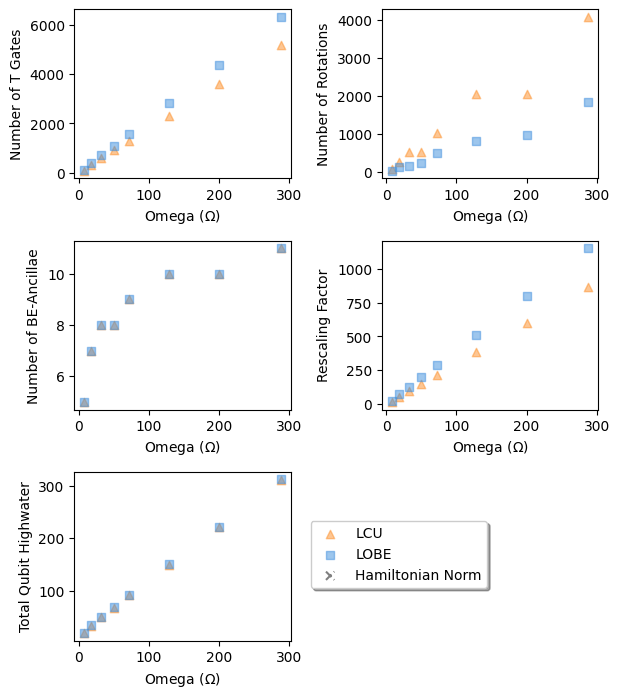

In [11]:
import matplotlib.pyplot as plt
from colors import *

fig, axes = plt.subplots(3, 2, figsize=(16 / 2.54, 18 / 2.54))

axes[0][0].scatter(numbers_of_qubits, [4*LCU_DATA[i][0].number_of_elbows for i in range(len(numbers_of_qubits))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][0].scatter(numbers_of_qubits, [4*LOBE_DATA[i][0].number_of_elbows for i in range(len(numbers_of_qubits))], color=BLUE, marker='s', alpha = 0.5)
axes[0][0].set_ylabel("Number of T Gates")
axes[0][0].set_xlabel("Omega ($\Omega$)")

axes[0][1].scatter(numbers_of_qubits, [LCU_DATA[i][0].number_of_nonclifford_rotations for i in range(len(numbers_of_qubits))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][1].scatter(numbers_of_qubits, [LOBE_DATA[i][0].number_of_nonclifford_rotations for i in range(len(numbers_of_qubits))], color=BLUE, marker='s', alpha = 0.5)
axes[0][1].set_ylabel("Number of Rotations")
axes[0][1].set_xlabel("Omega ($\Omega$)")

axes[1][0].scatter(numbers_of_qubits, [LCU_DATA[i][2] for i in range(len(numbers_of_qubits))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][0].scatter(numbers_of_qubits, [LOBE_DATA[i][2] for i in range(len(numbers_of_qubits))], color=BLUE, marker='s', alpha = 0.5)
axes[1][0].set_ylabel("Number of BE-Ancillae")
axes[1][0].set_xlabel("Omega ($\Omega$)")

axes[1][1].scatter(numbers_of_qubits, [LCU_DATA[i][1] for i in range(len(numbers_of_qubits))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][1].scatter(numbers_of_qubits, [LOBE_DATA[i][1] for i in range(len(numbers_of_qubits))], color=BLUE, marker='s', alpha = 0.5)
# axes[1][1].scatter(numbers_of_qubits, [operator_norms[i] for i in range(len(numbers_of_qubits))], color="black", marker='x', ls='--', alpha = 0.5)
axes[1][1].set_ylabel("Rescaling Factor")
axes[1][1].set_xlabel("Omega ($\Omega$)")

axes[2][0].scatter(numbers_of_qubits, [LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + numbers_of_qubits[i] + 1 for i in range(len(numbers_of_qubits))], color=ORANGE, marker='^', alpha = 0.5, label="LCU")
axes[2][0].scatter(numbers_of_qubits, [LOBE_DATA[i][0].ancillae_highwater() + LOBE_DATA[i][2] + numbers_of_qubits[i] + 1 for i in range(len(numbers_of_qubits))], color=BLUE, marker='s', alpha = 0.5, label="LOBE")
axes[2][0].scatter([], [], color="black", marker='x', ls='--', alpha = 0.5, label="Hamiltonian Norm")
axes[2][0].set_ylabel("Total Qubit Highwater")
axes[2][0].set_xlabel("Omega ($\Omega$)")

fig.delaxes(axes[2][1])
plt.tight_layout()
axes[2][0].legend(loc='upper center', bbox_to_anchor=(1.5, 0.75),
          fancybox=True, shadow=True, ncol=1)

In [8]:
from src.lobe.bosonic import _get_bosonic_rotation_angles

In [20]:
_get_bosonic_rotation_angles(7, 3, 0)

[3.141592653589793,
 3.141592653589793,
 3.141592653589793,
 2.876295295058717,
 2.6061802758487094,
 2.2785726019120673,
 1.8757946179051066,
 1.3443768896042645]

In [18]:
np.arccos(np.sqrt(1 / 7)) * 2 

2.366399280279432

In [21]:
qub = cirq.LineQubit(0)
cirq.Circuit(cirq.ry(np.pi).on(qub)).unitary()

array([[ 0.-0.j, -1.-0.j],
       [ 1.+0.j,  0.+0.j]])